In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [21]:
def data_loading(data_path, label_path, batch_size, train_ratio=0.8):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    # Apply SMOTE
    smote = SMOTE()
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)

    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [25]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Train the model
def train_lstm(train_loader, test_loader, input_dim, hidden_dim=50, output_dim=1, epochs=10, lr=0.001):
    model = LSTMModel(input_dim, hidden_dim, output_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train model
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate model
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            preds = torch.sigmoid(outputs) > 0.5
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

# Feature Ablation: Evaluate the impact of each feature
def feature_ablation(train_loader, test_loader, num_features):
    accuracies = []
    for i in range(num_features):
        # Create subset of features
        train_loader_subset = [(inputs[:, :i+1], labels) for inputs, labels in train_loader]
        test_loader_subset = [(inputs[:, :i+1], labels) for inputs, labels in test_loader]
        
        accuracy = train_lstm(train_loader_subset, test_loader_subset, input_dim=train_loader.dataset[0][0].shape[1] - 1)
        accuracies.append(accuracy)
        print(f"Feature {i} accuracy: {accuracy}")

    return accuracies

# Example usage
data_path = 'data.pt'
label_path = 'label.pt'
batch_size = 32

train_loader, test_loader = data_loading(data_path, label_path, batch_size)
num_features = 24  # Number of features

# Perform feature ablation
accuracies = feature_ablation(train_loader, test_loader, num_features)

(326, 24, 100)


RuntimeError: input.size(-1) must be equal to input_size. Expected 99, got 100

In [3]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=24, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(32*91, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x


In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [5]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n

## Training

wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin


(326, 24, 100)

Epoch 1/100.
Training accuracy: 48.846153259277344. Testing accuracy: 54.54545593261719. Duration: 0.449s.

Epoch 2/100.
Training accuracy: 51.153846740722656. Testing accuracy: 45.45454406738281. Duration: 0.024s.

Epoch 3/100.
Training accuracy: 51.153846740722656. Testing accuracy: 45.45454406738281. Duration: 0.026s.

Epoch 4/100.
Training accuracy: 58.46154022216797. Testing accuracy: 53.030303955078125. Duration: 0.041s.

Epoch 5/100.
Training accuracy: 48.846153259277344. Testing accuracy: 54.54545593261719. Duration: 0.040s.

Epoch 6/100.
Training accuracy: 48.846153259277344. Testing accuracy: 54.54545593261719. Duration: 0.036s.

Epoch 7/100.
Training accuracy: 48.846153259277344. Testing accuracy: 54.54545593261719. Duration: 0.028s.

Epoch 8/100.
Training accuracy: 48.846153259277344. Testing accuracy: 54.54545593261719. Duration: 0.024s.

Epoch 9/100.
Training accuracy: 49.230770111083984. Testing accuracy: 54.54545593261719. Duration: 0.018s.

Epoch 10/100

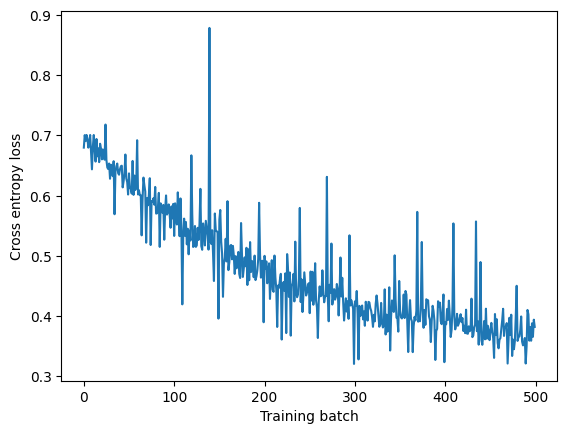

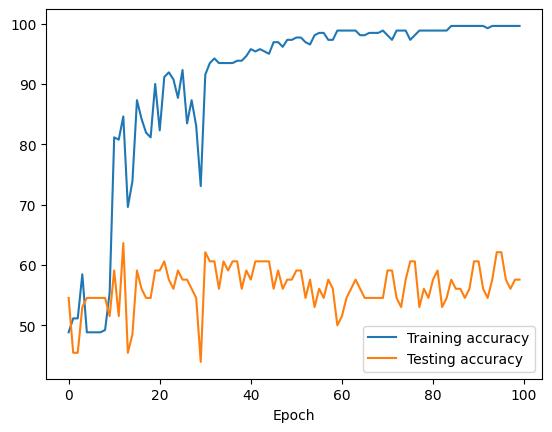

test_acc,▅▁▅▅▆█▆▅▆▆▆▅▇▅▆▅▆▇▅▆▆▆▅▅▃▆▅▅▆▄▇▅▆▅▅▅▅▆▆▆
train_acc,▁▁▁▁▅▆▆▆▆▇▇▆▇▇▇▇▇▇██████████████████████
train_loss,▆▆▅▅▅▄▅▄▅▃▅█▂▃▃▄▃▂▂▃▂▅▂▄▁▂▂▃▁▄▁▂▄▂▄▂▁▁▂▂
test_acc,57.57576
train_acc,99.61539
train_loss,0.38204


In [6]:
wandb.init(
    # set the wandb project where this run will be logged
    project="NASA_turbo_fan",
    name= "feature selection",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.6
    }
)
config = wandb.config

train_loader, test_loader = data_loading(data_path='data.pt', label_path='label.pt',batch_size= config.batch_size)

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

# Create an instance of the CNN
model = SimpleCNN(dropout=config.dropout)

# Loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.decay)

model.to(device)

num_epochs = 100
for epoch in range(config.epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_loader:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`
        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        train_loss = float(l)
        losses.append(train_loss) # Stores the loss for this batch

    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    train_acc = evaluate_metric(model, train_loader, correct)
    train_accs.append(train_acc)
    test_acc = evaluate_metric(model, test_loader, correct)
    test_accs.append(test_acc)
    metrics = {"train_loss": train_loss,
               "train_acc": train_acc,
               "test_acc": test_acc}
    wandb.log(metrics)

    end_time = time.perf_counter()

    print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()
wandb.finish()

In [7]:
print('max test accuracy {}'.format(max(test_accs)))

max test accuracy 63.6363639831543
